In [2]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from openai import AzureOpenAI
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# Load the JSONL file
data = []
with open('balanced_trip_summaries.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the first few rows and basic stats
print(f"Dataset size: {len(df)} records")
print("\nTransport mode distribution:")
print(df['transport_mode'].value_counts())
print("\nFirst few records:")
print(df.head())

Dataset size: 25 records

Transport mode distribution:
transport_mode
bike      5
bus       5
car       5
others    5
walk      5
Name: count, dtype: int64

First few records:
  transport_mode                                            summary
0           bike  Trip Summary:\n- Start: 2008-05-10 16:36:11 at...
1           bike  Trip Summary:\n- Start: 2008-05-14 16:00:36 at...
2           bike  Trip Summary:\n- Start: 2008-07-18 15:08:29 at...
3           bike  Trip Summary:\n- Start: 2008-07-09 12:34:11 at...
4           bike  Trip Summary:\n- Start: 2008-09-17 16:44:01 at...


In [5]:
# Initialize the Azure OpenAI client
azure_openai = AzureOpenAI(
    azure_endpoint="https://intelligencia-openai-lab02.openai.azure.com/",
    api_key="049425cc99184a619ff068082279749f",
    api_version="2024-02-15-preview"
)

In [6]:

# ## Define Inference Function

def predict_transport_mode(summary, model="gpt-4o", retry_attempts=3, retry_delay=2):
    """
    Predict the transport mode from a trip summary using Azure OpenAI.
    
    Args:
        summary (str): The trip summary text
        model (str): The GPT model to use
        retry_attempts (int): Number of retry attempts if API call fails
        retry_delay (int): Delay in seconds between retries
        
    Returns:
        str: Predicted transport mode
    """
    prompt = f"""
You are a transportation mode analysis expert. Analyze the trip summary below and determine the most likely mode of transportation used.

Pay close attention to these key indicators:
- Average speed and speed variations
- Acceleration patterns
- Number of turns and turn rates
- Duration and distance
- Start and end locations

The trip summary includes various metrics that can help identify the transportation mode:
- Walking typically has slow speeds (3-6 km/h), low acceleration, and potentially high turn rates
- Biking usually shows moderate speeds (10-20 km/h), moderate acceleration, and varied turn patterns
- Bus travel shows moderate speeds (15-30 km/h), lower acceleration, and fewer turns per km
- Cars typically have higher speeds (30-80 km/h), higher acceleration capabilities, and varied turn patterns
- Subway/train travel often has high speeds, very consistent acceleration/deceleration patterns

Based on your analysis, classify the transportation mode as one of: bike, bus, car, subway, train, or walk.
Only respond with the single word for the most likely transportation mode.

Trip Summary:
{summary}
"""
    
    for attempt in range(retry_attempts):
        try:
            response = azure_openai.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a transportation mode analysis expert that provides concise, single-word answers."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,  # Keep it deterministic
                max_tokens=10    # We only need a short answer
            )
            
            predicted_mode = response.choices[0].message.content.strip().lower()
            
            # Clean up the prediction if needed
            if predicted_mode in ['bike', 'bicycle', 'cycling']:
                return 'bike'
            elif predicted_mode in ['bus', 'coach']:
                return 'bus'
            elif predicted_mode in ['car', 'taxi', 'automobile', 'drive']:
                return 'car'
            elif predicted_mode in ['subway', 'metro', 'underground']:
                return 'subway'
            elif predicted_mode in ['train', 'rail']:
                return 'train'
            elif predicted_mode in ['walk', 'walking', 'on foot']:
                return 'walk'
            else:
                return predicted_mode  # Return as is if not one of the expected modes
            
        except Exception as e:
            if attempt < retry_attempts - 1:
                print(f"API call failed: {e}. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"API call failed after {retry_attempts} attempts: {e}")
                return "error"  # Return error indication if all retries fail

In [5]:

# Test the function with a single example
test_summary = df.iloc[0]['summary']
true_mode = df.iloc[0]['transport_mode']

print(f"\nTest summary:\n{test_summary}\n")
print(f"True transport mode: {true_mode}")


Test summary:
Trip Summary:
- Start: 2011-11-08 20:48:08 at 知春路, 知春东里社区, 中关村街道, 海淀区, 北京市, 100086, 中国
- End: 2011-11-08 20:52:33 at 中关村街道, 海淀区, 北京市, 100098, 中国
- Duration: 0 days 00:04:25
- Distance: 0.96 km
- Average Speed: 12.98 km/h
- Average Bearing Change: 63.22°
- Max Speed: 15.78 km/h
- Min Speed: 0.00 km/h
- Speed Variability: 2.57 km/h
- Average Acceleration: 0.01 m/s²
- Max Acceleration: 0.70 m/s²
- Number of Turns: 10
- Turn Rate: 2.31 turns/min
- Average Turn Angle: 63.22°
- Turn Angle Variability: 119.39°
- Transport Mode: bike

True transport mode: bike


In [16]:

# ## Run Inference on the Full Dataset
#
# Note: This will make API calls for each example and may incur costs. You might want to run this on a subset first.

def run_inference(df, model="gpt-4o", sample_size=None):
    """
    Run inference on the dataset and return results.
    
    Args:
        df (DataFrame): The dataset
        model (str): The GPT model to use
        sample_size (int): Optional sample size to limit API calls
        
    Returns:
        DataFrame: Original dataframe with predictions added
    """
    # If sample_size is provided, take a stratified sample
    if sample_size and sample_size < len(df):
        df_sample = df.groupby('transport_mode').apply(lambda x: x.sample(min(len(x), sample_size // len(df['transport_mode'].unique())))).reset_index(drop=True)
        print(f"Using a stratified sample of {len(df_sample)} examples")
    else:
        df_sample = df
        print(f"Using all {len(df_sample)} examples")
    
    # Make a copy to avoid modifying the original
    results_df = df_sample.copy()
    results_df['predicted_mode'] = None
    
    # For tracking progress
    total_cost_estimate = 0
    
    # Run inference
    for idx, row in tqdm(results_df.iterrows(), total=len(results_df), desc=f"Running inference with {model}"):
        summary = row['summary']
        
        # Make prediction
        predicted_mode = predict_transport_mode(summary, model=model)
        results_df.at[idx, 'predicted_mode'] = predicted_mode
        
        # Estimate cost (very rough estimate)
        if model.startswith('gpt-4'):
            # GPT-4 costs more
            total_cost_estimate += 0.01  # Approximate cost per API call
        else:
            total_cost_estimate += 0.002  # Approximate cost per API call for GPT-3.5
            
        # Sleep to avoid rate limiting
        time.sleep(0.5)
    
    print(f"\nEstimated API cost: ${total_cost_estimate:.2f}")
    
    return results_df


# Set this to a small number to test, like 5-10 examples per mode
SAMPLE_SIZE = 80  # This would be 10 examples per mode for 6 modes

# Choose the model to use
MODEL = "gpt-4o"  # Cheaper option for testing
# MODEL = "gpt-4o"       # More accurate but more expensive

# Run inference
# When ready to run, uncomment the line below:
results_df = run_inference(df, model=MODEL, sample_size=SAMPLE_SIZE)

Using a stratified sample of 80 examples


Running inference with gpt-4o: 100%|██████████| 80/80 [01:59<00:00,  1.50s/it]


Estimated API cost: $0.80


In [15]:
print(results_df.head())

  transport_mode                                            summary  \
0           bike  Trip Summary:\n- Start: 2008-05-30 01:26:41 at...   
1           bike  Trip Summary:\n- Start: 2011-11-04 19:40:10 at...   
2           bike  Trip Summary:\n- Start: 2023-09-15 14:15:23 at...   
3           bike  Trip Summary:\n- Start: 2023-08-15 07:30:00 at...   
4            bus  Trip Summary:\n- Start: 2011-11-08 02:04:35 at...   

  predicted_mode  
0           bike  
1           bike  
2            bus  
3            bus  
4            car  


In [8]:

# ## Evaluate Results

def evaluate_results(results_df):
    """
    Evaluate the results of the inference.
    
    Args:
        results_df (DataFrame): DataFrame with true and predicted modes
    """
    # Get predictions and true values
    y_true = results_df['transport_mode']
    y_pred = results_df['predicted_mode']
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get unique classes
    classes = sorted(results_df['transport_mode'].unique())
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate per-class accuracy
    per_class_acc = {}
    for cls in classes:
        mask = y_true == cls
        if mask.sum() > 0:  # Avoid division by zero
            per_class_acc[cls] = (y_pred[mask] == cls).mean()
        else:
            per_class_acc[cls] = 0
    
    # Plot per-class accuracy
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(per_class_acc.keys()), y=list(per_class_acc.values()))
    plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.xlabel('Transport Mode')
    plt.title('Per-Class Accuracy')
    plt.legend()
    plt.show()
    
    # Return the evaluation metrics for later comparison
    return {
        'accuracy': accuracy,
        'per_class_accuracy': per_class_acc,
        'classification_report': classification_report(y_true, y_pred, output_dict=True)
    }

Accuracy: 0.5875

Classification Report:
              precision    recall  f1-score   support

        bike       0.58      0.69      0.63        16
         bus       0.73      0.69      0.71        16
         car       0.56      0.56      0.56        16
      others       0.00      0.00      0.00        16
       train       0.00      0.00      0.00         0
        walk       0.70      1.00      0.82        16

    accuracy                           0.59        80
   macro avg       0.43      0.49      0.45        80
weighted avg       0.51      0.59      0.54        80



/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Us

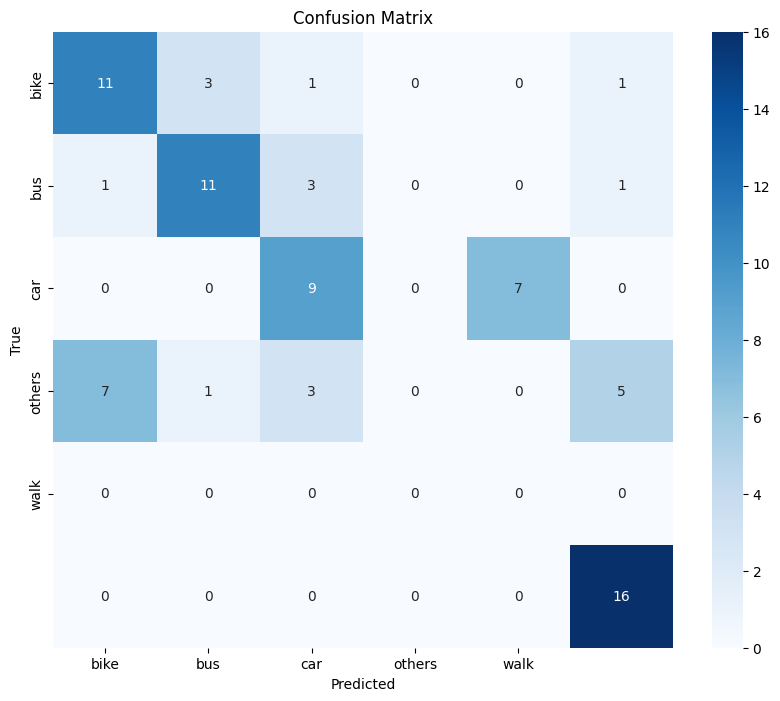

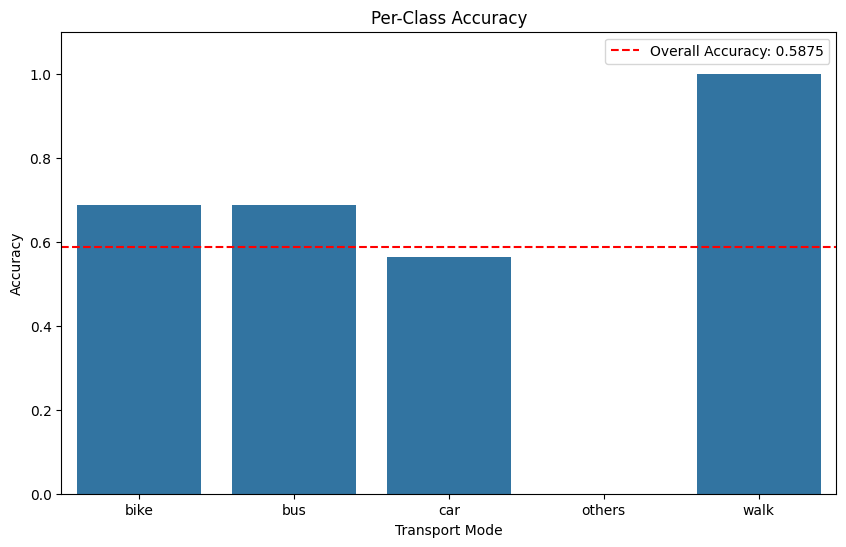

/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Us

In [17]:
metrics = evaluate_results(results_df)

In [ ]:

# ## Save Results
#
# Save the predictions and evaluation metrics for later comparison with fine-tuned models.

def save_results(results_df, metrics, model_name):
    """
    Save the results and metrics to files.
    
    Args:
        results_df (DataFrame): DataFrame with predictions
        metrics (dict): Evaluation metrics
        model_name (str): Name of the model used
    """
    # Create a timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    
    # Save the predictions
    filename = f"{model_name}_predictions_{timestamp}.csv"
    results_df.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")
    
    # Save the metrics
    metrics_filename = f"{model_name}_metrics_{timestamp}.json"
    with open(metrics_filename, 'w') as f:
        # Convert classification report to a serializable format
        if 'classification_report' in metrics:
            metrics['classification_report'] = {
                k: {kk: float(vv) for kk, vv in v.items()} 
                if isinstance(v, dict) else float(v)
                for k, v in metrics['classification_report'].items()
            }
        json.dump(metrics, f, indent=2)
    print(f"Saved metrics to {metrics_filename}")

# When you have results, uncomment to save
# save_results(results_df, metrics, MODEL)

In [ ]:

# ## Running the script
if __name__ == "__main__":
    print("\n" + "="*50)
    print("GPT Inference Script for Transport Mode Prediction")
    print("="*50)
    
    print("\nTo run inference with GPT:")
    print("1. Make sure your OpenAI API key is set")
    print("2. Uncomment the results_df = run_inference() line")
    print("3. Uncomment the metrics = evaluate_results() line")
    print("4. Uncomment the save_results() line if you want to save the results")
    
    print("\nNOTE: This script will make API calls to OpenAI which may incur costs.")
    print("      You can control the cost by setting a small SAMPLE_SIZE.") 